In [18]:
from scipy.io import mmread
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# 1. Load the matrix
matrix = mmread("matrix.mtx").tocsc()  # Use .tocsc() or .tocsr() for efficient slicing

# 2. Load genes or features
# Try both 'genes.tsv' or 'features.tsv' depending on your version of Cell Ranger
try:
    genes = pd.read_csv("genes.tsv", header=None, sep="\t")
except FileNotFoundError:
    genes = pd.read_csv("features.tsv", header=None, sep="\t")

# 3. Load barcodes
barcodes = pd.read_csv("barcodes.tsv", header=None)

# 4. Rename for convenience
gene_names = genes.iloc[:, 1].values  # Column 1 = gene names
cell_barcodes = barcodes.iloc[:, 0].values  # Column 0 = barcode strings

# 5. Convert sparse matrix to dense (if manageable) and create DataFrame
# WARNING: Dense conversion is memory-intensive; only do this if matrix is small enough
df = pd.DataFrame.sparse.from_spmatrix(matrix.T, index=cell_barcodes, columns=gene_names)


# Optional: convert to dense DataFrame (memory intensive)
# df_dense = df.sparse.to_dense()

# Show the shape and head
print(f"Shape: {df.shape}")  # (num_cells, num_genes)
print(df.head())


Shape: (3463, 11187)
                          Mrpl15  Lypla1  Tcea1  Atp6v1h  Rb1cc1  \
DVFL2_AAACCTGAGGACCACA-1       8       1      4        1       1   
DVFL2_AAACCTGCAAAGTCAA-1       2       1      0        0       0   
DVFL2_AAACCTGCAATCAGAA-1       2       1      1        1       0   
DVFL2_AAACCTGCACTTGGAT-1       5       1      4        0       0   
DVFL2_AAACCTGCAGTATAAG-1       1       1      0        2       0   

                          4732440D04Rik  Pcmtd1  Rrs1  Vcpip1  Sgk3  ...  \
DVFL2_AAACCTGAGGACCACA-1              0       1     2       0     1  ...   
DVFL2_AAACCTGCAAAGTCAA-1              0       0     2       1     2  ...   
DVFL2_AAACCTGCAATCAGAA-1              0       1     7       1     0  ...   
DVFL2_AAACCTGCACTTGGAT-1              0       1     6       0     1  ...   
DVFL2_AAACCTGCAGTATAAG-1              0       0     0       0     0  ...   

                          mt-Co3  mt-Nd3  mt-Nd4l  mt-Nd4  mt-Nd5  mt-Nd6  \
DVFL2_AAACCTGAGGACCACA-1     120    

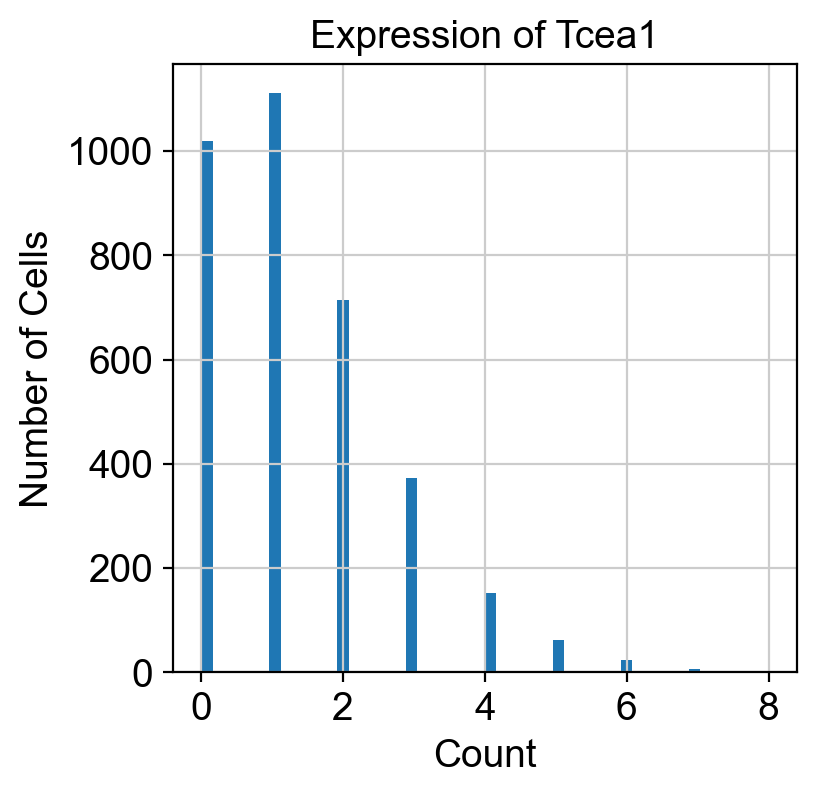

In [19]:
import matplotlib.pyplot as plt

gene = "Tcea1"  # Replace with a gene in your dataset

if gene in df.columns:
    plt.hist(df[gene].astype(float), bins=50)
    plt.title(f"Expression of {gene}")
    plt.xlabel("Count")
    plt.ylabel("Number of Cells")
    plt.show()
else:
    print(f"Gene {gene} not found in dataset.")

In [20]:
from scipy.io import mmread
import numpy as np

# Load sparse matrix
mtx = mmread("matrix.mtx")

# Convert to dense NumPy array if small
dense_mtx = mtx.toarray()

# View first few rows
print(dense_mtx)

[[8 2 2 ... 5 5 0]
 [1 1 1 ... 3 3 0]
 [4 0 1 ... 0 3 2]
 ...
 [1 2 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [2 0 1 ... 0 0 0]]


✅ Loaded data: (2730, 3451) (cells, genes)


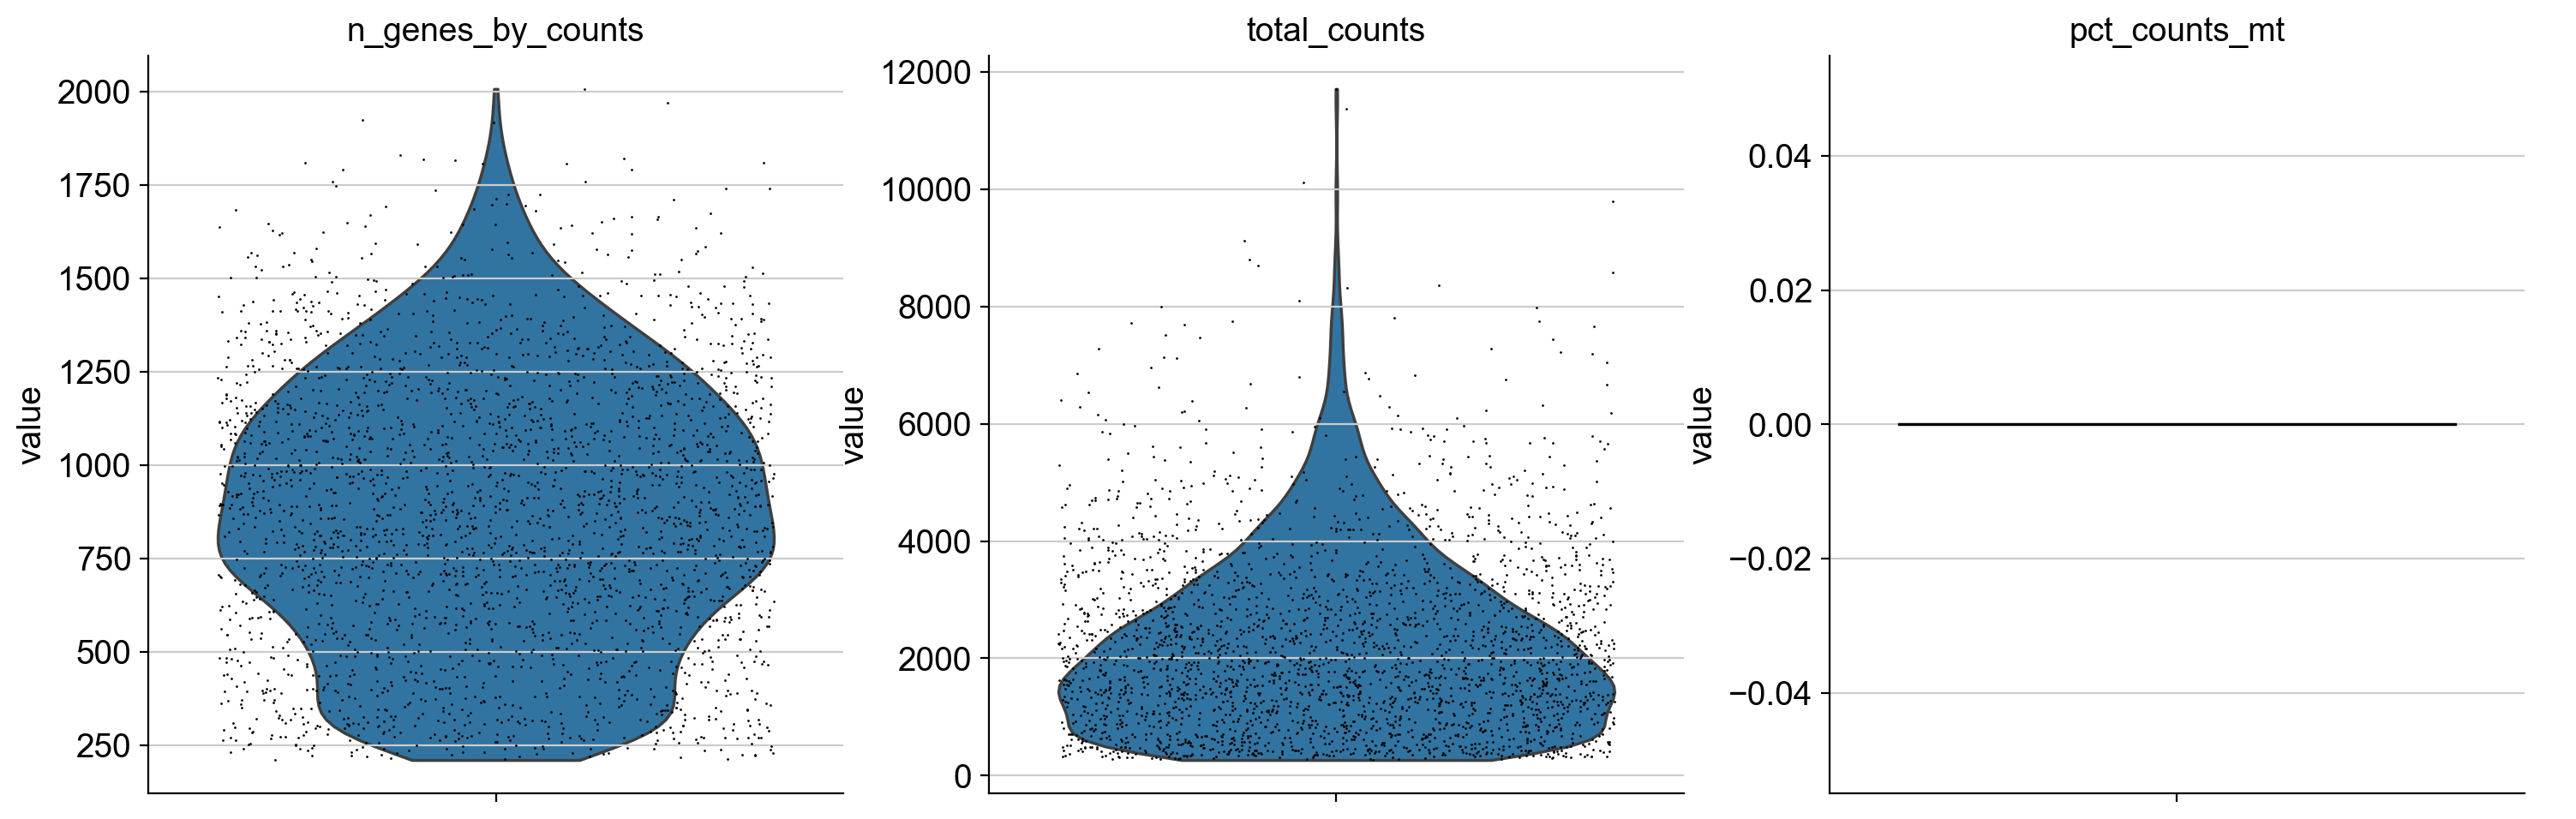

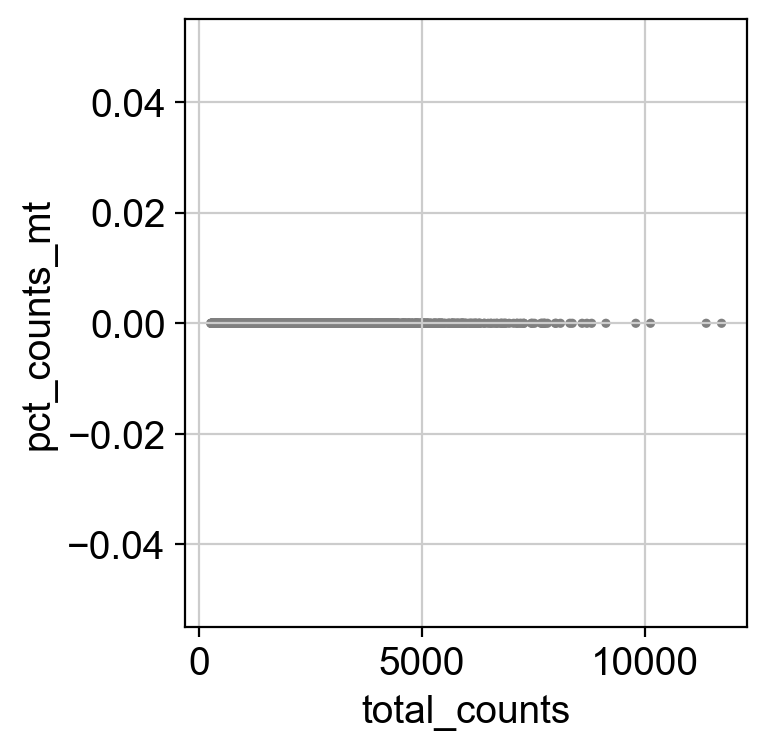

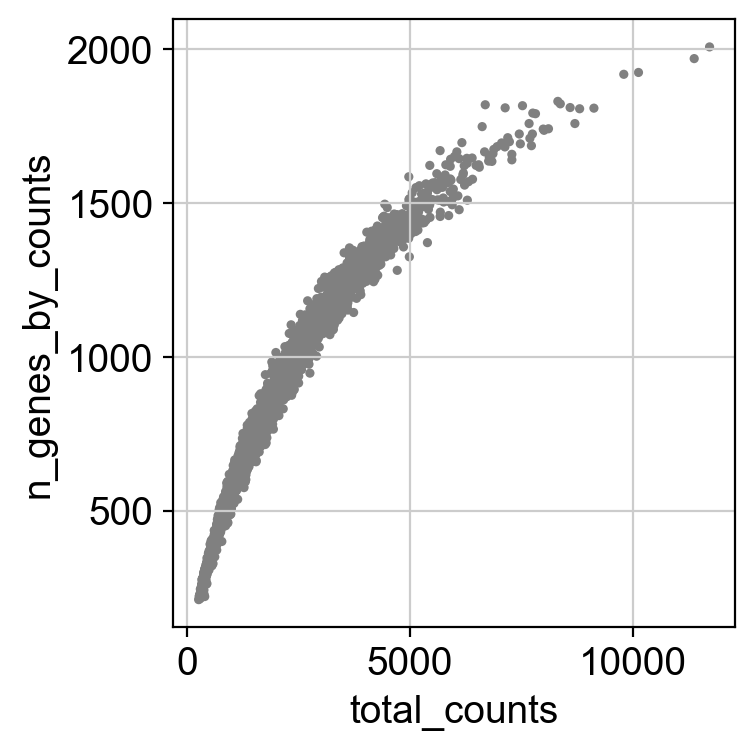

🔎 Before filtering: (2730, 3267)
✅ After filtering: (2589, 3267)


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


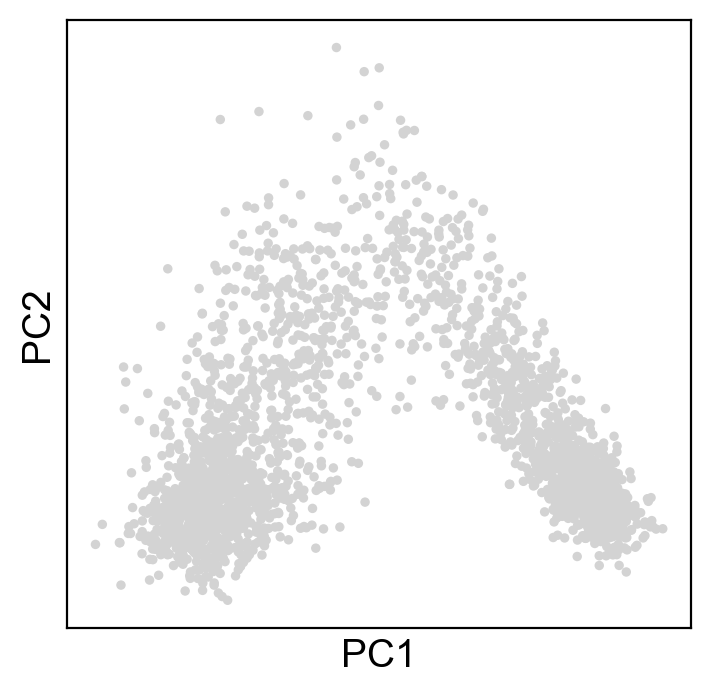

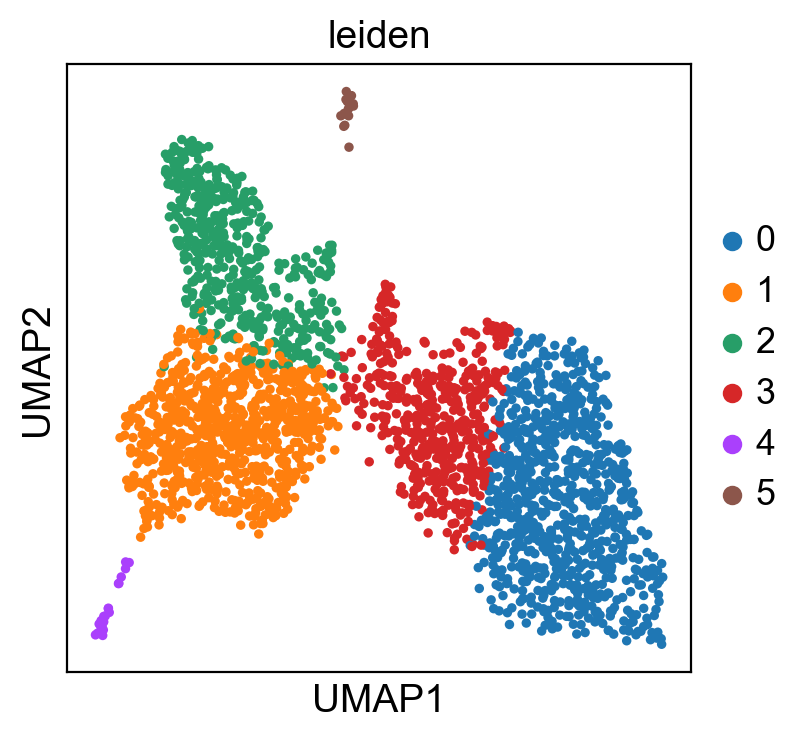

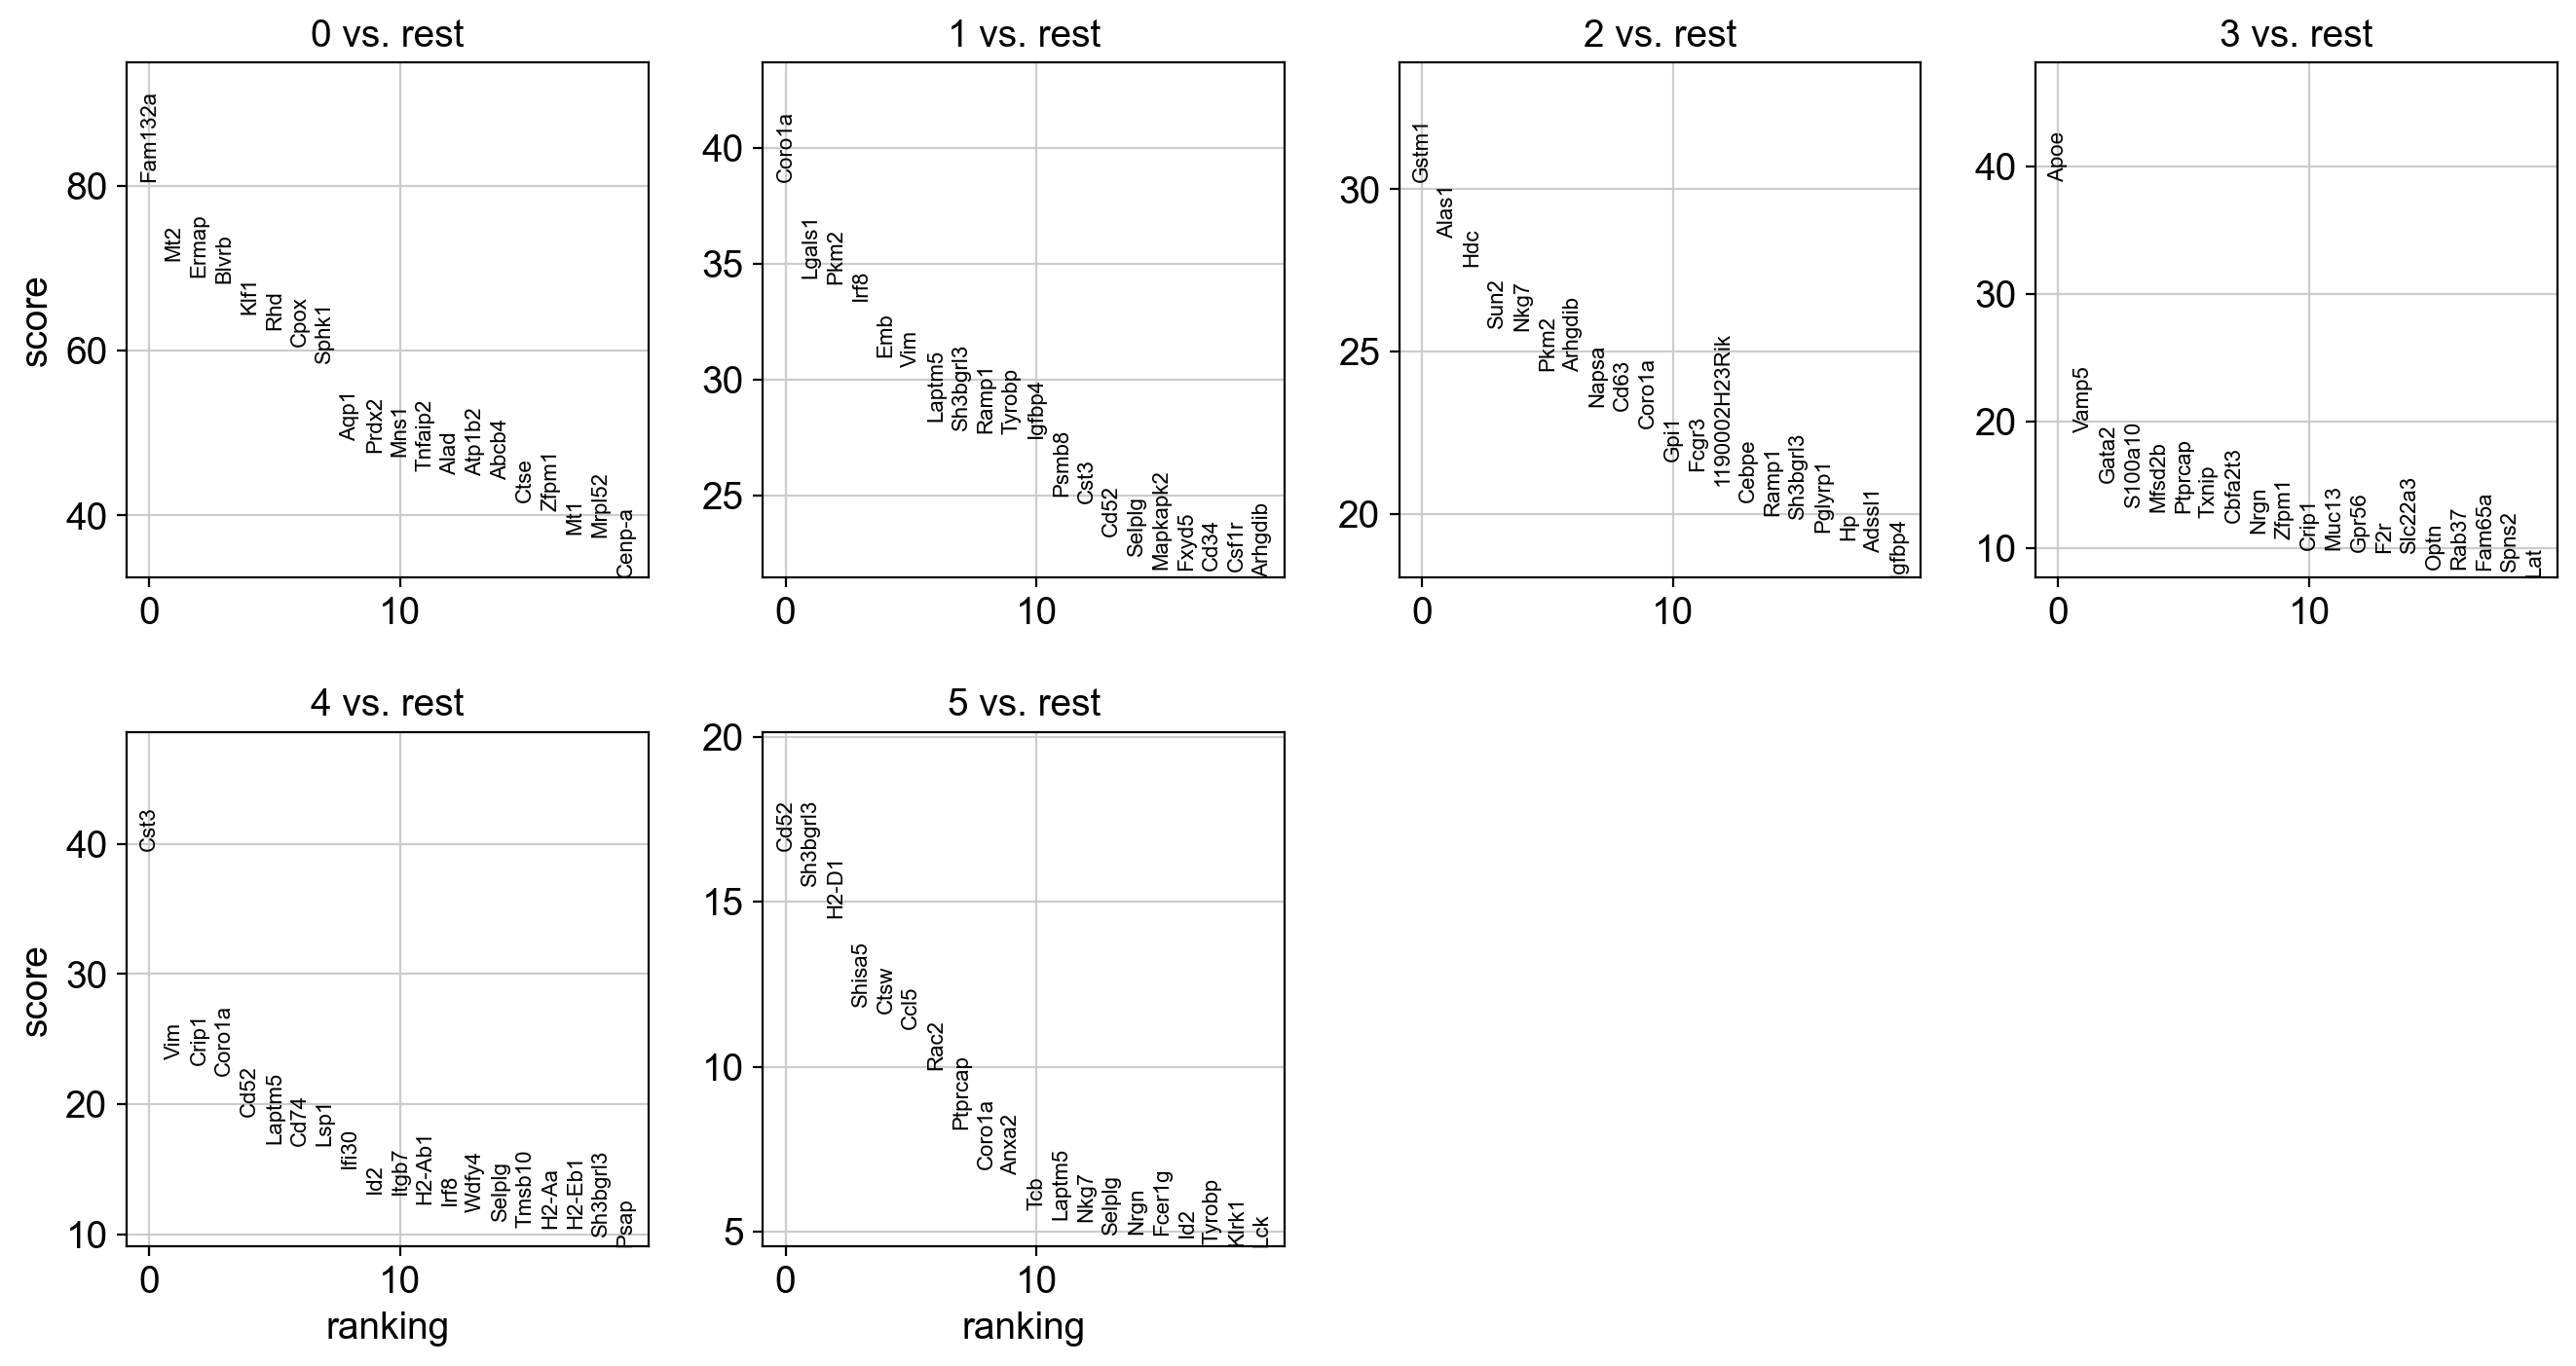

saving figure to file figures/umap_clusters.png


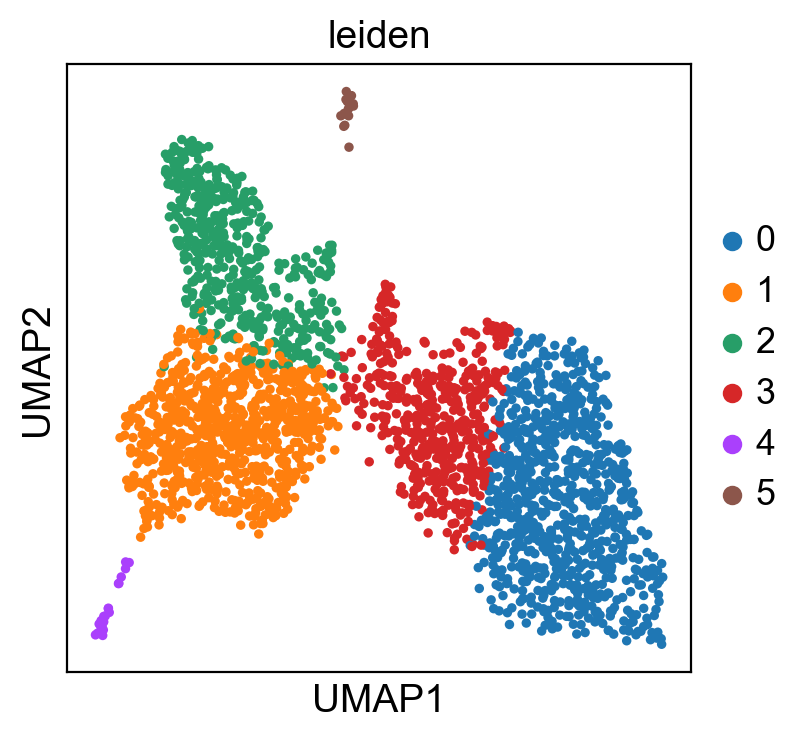

✅ Pipeline complete!
 - processed_data.h5ad
 - marker_genes.csv
 - UMAP plot saved


In [21]:
# 📦 Imports
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────
# 🔧 Scanpy Settings
# ──────────────────────────────────────────────
sc.settings.verbosity = 3
sc.set_figure_params(dpi=100, facecolor='white')

# ──────────────────────────────────────────────
# 📁 Load Data
# ──────────────────────────────────────────────
# Example dataset — replace with your actual 10x directory
# data_dir = "path/to/10x_data"
# adata = sc.read_10x_mtx(data_dir, var_names='gene_symbols', cache=True)

adata = sc.datasets.paul15()  # REMOVE this line when using real data
print(f"✅ Loaded data: {adata.shape} (cells, genes)")

# ──────────────────────────────────────────────
# 🧼 Step 1: Basic QC
# ──────────────────────────────────────────────
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=30)

# Annotate mitochondrial genes
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

# Visualize QC metrics
sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

# ──────────────────────────────────────────────
# 🧼 Step 2: Filtering
# ──────────────────────────────────────────────
print("🔎 Before filtering:", adata.shape)

# Adjust thresholds as needed
adata = adata[(adata.obs.n_genes_by_counts < 6000) &
              (adata.obs.n_genes_by_counts > 300) &
              (adata.obs.pct_counts_mt < 20), :]

print("✅ After filtering:", adata.shape)

if adata.n_obs == 0:
    raise ValueError("❌ All cells removed during filtering — adjust thresholds.")

# ──────────────────────────────────────────────
# 🧪 Step 3: Normalize & Log-transform
# ──────────────────────────────────────────────
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# ──────────────────────────────────────────────
# 🔍 Step 4: Highly Variable Genes
# ──────────────────────────────────────────────
sc.pp.highly_variable_genes(
    adata,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5
)
adata = adata[:, adata.var.highly_variable]

# ──────────────────────────────────────────────
# 🔬 Step 5: Scale & PCA
# ──────────────────────────────────────────────
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

# ──────────────────────────────────────────────
# 🤝 Step 6: Neighbors & UMAP
# ──────────────────────────────────────────────
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

# ──────────────────────────────────────────────
# 🔖 Step 7: Clustering
# ──────────────────────────────────────────────
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color=['leiden'])

# ──────────────────────────────────────────────
# 🧬 Step 8: Marker Gene Discovery
# ──────────────────────────────────────────────
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

marker_df = sc.get.rank_genes_groups_df(adata, group=None)
marker_df.to_csv("marker_genes.csv", index=False)

# ──────────────────────────────────────────────
# 💾 Step 9: Save Results
# ──────────────────────────────────────────────
adata.write("processed_data.h5ad")
sc.pl.umap(adata, color=['leiden'], save="_clusters.png")

print("✅ Pipeline complete!")
print(" - processed_data.h5ad")
print(" - marker_genes.csv")
print(" - UMAP plot saved")


In [116]:
# Step 1: Build graph (Scanpy or custom)
# Step 2: Train GNN to embed state
# Step 3: Create Gym-style environment for cell fate transitions
# Step 4: Train RL agent with GNN-based policy


#scRNA-seq data → Gene Expression Matrix → GRN Inference (SCENIC / GRNBoost)
#         ↓
#    Graph: Genes = nodes, regulation = edges
#         ↓
#    GNN → encodes current cell state from GRN
#         ↓
#RL Agent (PPO, A2C, etc.)
 #        ↓
# Selects action (TF activation, perturbation)
  #       ↓
#Environment simulates cell transition → Next GRN-encoded state


In [22]:
import scanpy as sc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from scipy.sparse import issparse
from torch_geometric.nn import GCNConv
from torch_geometric.utils import dense_to_sparse
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# ----------------- Repro seeds & device -----------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device("cpu")  # CPU for multiprocess pickling; change if single-GPU

# ----------------- Config / Hyperparams -----------------
N_GENES_SELECT = 20
GCN_HIDDEN = 64
GCN_EMB = 32
AE_TRAIN_EPOCHS = 500
ACTION_MAGNITUDE = 0.25
MAX_STEPS = 50

# ----------------- Adaptive Threshold Class -----------------
class PerGeneAdaptiveThreshold:
    def __init__(self, gene_list, alpha=0.1):
        self.thresholds = {int(g): 0.0 for g in gene_list}
        self.alpha = alpha
    def update(self, gene_rewards):
        for gene_id, reward in gene_rewards.items():
            if reward is None or (isinstance(reward, float) and np.isnan(reward)):
                continue
            gid = int(gene_id)
            prev = self.thresholds.get(gid, 0.0)
            self.thresholds[gid] = self.alpha * float(reward) + (1 - self.alpha) * prev
    def get(self, gene_id):
        return float(self.thresholds.get(int(gene_id), 0.0))

# ----------------- Step 1: Load & preprocess data -----------------
adata = sc.read_10x_mtx("Untitled Folder 3/")
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, inplace=True)
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)

# ----------------- Step 2: Pseudotime inference -----------------
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.diffmap(adata)
adata.uns['iroot'] = 0
sc.tl.dpt(adata)
pseudotime = adata.obs['dpt_pseudotime'].values

# ----------------- Step 3: Gene selection -----------------
X_full = adata.X.toarray() if issparse(adata.X) else np.asarray(adata.X)
y = pseudotime
mi_scores = mutual_info_regression(X_full, y, discrete_features=False, random_state=SEED)
N = min(N_GENES_SELECT, X_full.shape[1])
top_gene_indices = np.argsort(mi_scores)[-N:]
X = X_full[:, top_gene_indices].astype(np.float32)
adata = adata[:, top_gene_indices]
selected_gene_names = list(adata.var_names)

# ----------------- Step 4: Train/test split and normalization -----------------
n_cells, n_genes = X.shape
indices = np.arange(n_cells)
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=SEED, shuffle=True)
expression_train = X[train_idx]
expression_test = X[test_idx]
pseudotime_train = pseudotime[train_idx]
pseudotime_test = pseudotime[test_idx]
gene_means = expression_train.mean(axis=0)
gene_stds = expression_train.std(axis=0) + 1e-8
expression_train = (expression_train - gene_means) / gene_stds
expression_test = (expression_test - gene_means) / gene_stds
X = np.vstack([expression_train, expression_test])

# ----------------- Step 5: Adjacency matrix -----------------
X_full_selected = X_full[:, top_gene_indices]
peak_pt = np.zeros(n_genes, dtype=float)
order = np.argsort(pseudotime)
for g in range(n_genes):
    vals = X_full_selected[order, g]
    peak_idx = int(np.nanargmax(vals))
    peak_pt[g] = pseudotime[order][peak_idx]
corr_matrix = np.corrcoef(np.vstack([expression_train, expression_test]).T)
adj_matrix = np.zeros_like(corr_matrix)
corr_threshold = 0.1
for i in range(n_genes):
    for j in range(n_genes):
        if i == j:
            continue
        if peak_pt[i] < peak_pt[j] and abs(corr_matrix[i, j]) >= corr_threshold:
            adj_matrix[i, j] = float(corr_matrix[i, j])
adj_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
edge_index, edge_weight = dense_to_sparse(adj_tensor)
edge_index = edge_index.long().cpu()
edge_weight = edge_weight.float().cpu()

# ----------------- Step 6: GCN Autoencoder -----------------
class GCN_AE(nn.Module):
    def __init__(self, in_dim=1, hidden_dim=GCN_HIDDEN, emb_dim=GCN_EMB):
        super().__init__()
        self.enc1 = GCNConv(in_dim, hidden_dim)
        self.enc2 = GCNConv(hidden_dim, emb_dim)
        self.dec = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, in_dim)
        )
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        recon = self.dec(emb)
        return recon, emb

mean_expr = np.mean(expression_train, axis=0).reshape(-1, 1).astype(np.float32)
x_input = torch.tensor(mean_expr)
gcn_ae = GCN_AE(in_dim=1).to(DEVICE)
opt = torch.optim.Adam(gcn_ae.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.MSELoss()
gcn_ae.train()
print("\n--- Pretraining GCN-AE ---")
for epoch in range(AE_TRAIN_EPOCHS):
    opt.zero_grad()
    recon, emb = gcn_ae(x_input.to(DEVICE), edge_index.to(DEVICE))
    loss = loss_fn(recon.squeeze(), x_input.squeeze())
    loss.backward()
    opt.step()
    if (epoch + 1) % 50 == 0:
        print(f"AE epoch {epoch+1}/{AE_TRAIN_EPOCHS} loss {loss.item():.6f}")
torch.save(gcn_ae.state_dict(), "gcn_ae.pth")
gcn_ae.eval()

# ----------------- Step 7: GCN Encoder -----------------
class GeneGCN_Encoder(nn.Module):
    def __init__(self, gcn_ae):
        super().__init__()
        self.enc1 = gcn_ae.enc1
        self.enc2 = gcn_ae.enc2
    def forward(self, x, edge_index):
        x = self.enc1(x, edge_index)
        x = F.relu(x)
        emb = self.enc2(x, edge_index)
        return emb

encoder = GeneGCN_Encoder(gcn_ae).to(DEVICE)
encoder.eval()
torch.save(encoder.state_dict(), "gcn_encoder.pth")

# ----------------- Step 8: Discrete CRISPR GRN Environment -----------------
class GRNEnvModelFreeCRISPR(gym.Env):
    """Discrete gene environment with CRISPR perturbations."""
    metadata = {"render_modes": ["human"]}

    def __init__(self, expression, pseudotime, max_steps=MAX_STEPS, adaptive_thresholds=None,
                 device='cpu', action_magnitude=ACTION_MAGNITUDE, perturb_prob=0.1, max_perturb=3):
        super().__init__()
        self.expression = np.asarray(expression, dtype=np.float32)
        self.pseudotime = np.asarray(pseudotime, dtype=np.float32)
        self.n_cells, self.n_genes = self.expression.shape
        self.max_steps = max_steps
        self.adaptive_thresholds = adaptive_thresholds
        self.device = device
        self.action_magnitude = action_magnitude
        self.perturb_prob = perturb_prob
        self.max_perturb = max_perturb

        # Discrete action: for each gene -1,0,+1
        self.action_space = spaces.Discrete(self.n_genes * 3)
        self.observation_space = spaces.Box(low=-5.0, high=5.0, shape=(self.n_genes,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        self.idx = np.random.randint(self.n_cells)
        self.state = self.expression[self.idx].copy()
        self.original_state = self.state.copy()

        eligible_idxs = np.where(self.pseudotime > self.pseudotime[self.idx])[0]
        if len(eligible_idxs) == 0:
            eligible_idxs = np.array([self.idx])
        target_idx = np.random.choice(eligible_idxs)
        self.target = self.expression[target_idx].copy()

        self.reward_gene = int(np.random.randint(self.n_genes))
        self.target_value = float(self.target[self.reward_gene])

        self.steps = 0
        self.history = [self.state.copy()]
        self.knockout_genes = set()
        self.overexpressed_genes = set()

        # Apply CRISPR perturbation at reset
        self._apply_crispr_perturbation()
        return self.state.copy(), {}

    def _apply_crispr_perturbation(self):
        n_perturb = np.random.randint(1, self.max_perturb + 1)
        for _ in range(n_perturb):
            gene = np.random.randint(0, self.n_genes)
            if np.random.rand() < 0.5:  # knockout
                self.state[gene] = 0.0
                self.knockout_genes.add(gene)
            else:  # overexpression
                self.state[gene] *= 2.0
                self.overexpressed_genes.add(gene)

    def step(self, action):
        # Convert discrete action to gene + direction
        gene_id = action // 3
        direction = (action % 3) - 1  # -1,0,+1
        self.state[gene_id] = np.clip(self.state[gene_id] + direction * self.action_magnitude, -5.0, 5.0)

        # Apply occasional CRISPR perturbation
        if np.random.rand() < self.perturb_prob:
            self._apply_crispr_perturbation()

        old_mse = float(np.mean((self.history[-1] - self.target)**2))
        new_mse = float(np.mean((self.state - self.target)**2))
        reward = old_mse - new_mse

        gene_improvement = (abs(self.original_state[self.reward_gene] - self.target[self.reward_gene])
                            - abs(self.state[self.reward_gene] - self.target[self.reward_gene]))
        reward += 0.2 * float(gene_improvement)

        if self.adaptive_thresholds:
            threshold = self.adaptive_thresholds.get(self.reward_gene)
            reward -= threshold

        self.steps += 1
        self.history.append(self.state.copy())

        terminated = self.steps >= self.max_steps
        truncated = False
        info = {"old_mse": old_mse, "new_mse": new_mse, "reward_gene": int(self.reward_gene)}

        return self.state.copy(), float(reward), terminated, truncated, info

    def render(self, mode='human'):
        print(f"Step {self.steps} - gene {self.reward_gene} value {self.state[self.reward_gene]:.4f}")
        print(f"Knockouts: {sorted(list(self.knockout_genes))}, Overexpressed: {sorted(list(self.overexpressed_genes))}")

# ----------------- Step 9: Environment & Training -----------------
gene_list = list(range(expression_train.shape[1]))
adaptive_thresholds = PerGeneAdaptiveThreshold(gene_list)

def make_env():
    return GRNEnvModelFreeCRISPR(expression_train, pseudotime_train, adaptive_thresholds)




/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca



--- Pretraining GCN-AE ---
AE epoch 50/500 loss 0.000000
AE epoch 100/500 loss 0.000000
AE epoch 150/500 loss 0.000000
AE epoch 200/500 loss 0.000000
AE epoch 250/500 loss 0.000000
AE epoch 300/500 loss 0.000000
AE epoch 350/500 loss 0.000000
AE epoch 400/500 loss 0.000000
AE epoch 450/500 loss 0.000000
AE epoch 500/500 loss 0.000000


In [41]:
# full_loRA_multistage_ppo_train_test.py
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, average_precision_score

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.callbacks import BaseCallback

# Import your GRN environment
#from your_grn_module import GRNEnvModelFreeCRISPR
#from your_threshold_module import PerGeneAdaptiveThreshold  # if thresholds are in a separate file

# --------------------------
# CONFIG
# --------------------------
SEED = 42
DEVICE = "cpu"
np.random.seed(SEED)
torch.manual_seed(SEED)

TOTAL_TIMESTEPS = 100_000
CONVEX_PHASE_STEPS =50_000
EVAL_EPISODES = 20
PLOT_DIR = "pseudotime_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# --------------------------
# Train retry helper
# --------------------------
def train_with_retry(model, total_timesteps, retries=2):
    for attempt in range(1, retries + 1):
        try:
            model.learn(total_timesteps=total_timesteps)
            break
        except Exception as e:
            print(f"Training error attempt {attempt}: {e}")
            if attempt == retries:
                raise
            print("Retrying...")

# --------------------------
# LoRA linear layer
# --------------------------
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank=4, alpha=1.0, bias=True, init_scale=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.rank = rank
        self.alpha = alpha
        self.register_buffer("_blend", torch.tensor(0.0))

        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5) * init_scale)

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)

        self.lora_A = nn.Parameter(torch.zeros(rank, in_features))
        self.lora_B = nn.Parameter(torch.zeros(out_features, rank))
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)

    def lora_weight(self):
        return (self.lora_B @ self.lora_A) * self.alpha

    def forward_convex(self, x, blend):
        L = self.lora_weight()
        combined = (1.0 - blend) * self.weight + blend * L
        return F.linear(x, combined, self.bias)

    def forward_nonconvex(self, x):
        L = self.lora_weight()
        return F.linear(x, self.weight + L, self.bias)

# --------------------------
# Features extractor
# --------------------------
class SimpleFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space, features_dim=32):
        super().__init__(observation_space, features_dim)
        input_dim = observation_space.shape[0]
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, features_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

# --------------------------
# LoRA MLP extractor
# --------------------------
class LoRAMLPExtractor(nn.Module):
    def __init__(self, input_dim, features_dim=32, lora_rank=4, lora_alpha=1.0, blend=0.3):
        super().__init__()
        self.shared = LoRALinear(input_dim, 64, rank=lora_rank, alpha=lora_alpha)
        self.policy_net = LoRALinear(64, features_dim, rank=lora_rank, alpha=lora_alpha)
        self.value_net = LoRALinear(64, features_dim, rank=lora_rank, alpha=lora_alpha)
        self.mode = "convex"
        self.blend = float(blend)
        self.latent_dim_pi = features_dim
        self.latent_dim_vf = features_dim

    def forward(self, features: torch.Tensor):
        h = features
        if self.mode == "convex":
            h = F.relu(self.shared.forward_convex(h, self.blend))
            latent_pi = F.relu(self.policy_net.forward_convex(h, self.blend))
            latent_vf = F.relu(self.value_net.forward_convex(h, self.blend))
        else:
            h = F.relu(self.shared.forward_nonconvex(h))
            latent_pi = F.relu(self.policy_net.forward_nonconvex(h))
            latent_vf = F.relu(self.value_net.forward_nonconvex(h))
        return latent_pi, latent_vf

    # SB3 compatibility methods
    def forward_actor(self, features: torch.Tensor) -> torch.Tensor:
        latent_pi, _ = self.forward(features)
        return latent_pi

    def forward_critic(self, features: torch.Tensor) -> torch.Tensor:
        _, latent_vf = self.forward(features)
        return latent_vf

# --------------------------
# LoRA policy
# --------------------------
class LoRAPolicy(ActorCriticPolicy):
    def _build_mlp_extractor(self):
        input_dim = self.features_extractor.features_dim
        self.mlp_extractor = LoRAMLPExtractor(input_dim, features_dim=32, lora_rank=8, lora_alpha=1.0, blend=0.3)

# --------------------------
# Convex -> Nonconvex callback
# --------------------------
class MultiStageLoRASwitchCallback(BaseCallback):
    def __init__(self, switch_at_timesteps:int, verbose=1):
        super().__init__(verbose)
        self.switch_at_timesteps = int(switch_at_timesteps)
        self.switched = False

    def _on_step(self) -> bool:
        if (not self.switched) and (self.num_timesteps >= self.switch_at_timesteps):
            policy = self.model.policy
            if hasattr(policy, "mlp_extractor") and isinstance(policy.mlp_extractor, LoRAMLPExtractor):
                policy.mlp_extractor.mode = "nonconvex"
                if self.verbose:
                    print(f"\n>>> Switched to nonconvex mode at timestep {self.num_timesteps}")
                self.switched = True
        return True

# --------------------------
# Environment factory
# --------------------------
def make_env_factory(expression, pseudotime, adaptive_thresholds=None, max_steps=50):
    def _init():
        return GRNEnvModelFreeCRISPR(expression=expression,
                                     pseudotime=pseudotime,
                                     max_steps=max_steps,
                                     adaptive_thresholds=adaptive_thresholds)
    return _init

# --------------------------
# Evaluation & plotting
# --------------------------
def evaluate_and_plot(model, algo_name, gene_names, expression, pseudotime, adaptive_thresholds=None, n_episodes=30):
    os.makedirs(PLOT_DIR, exist_ok=True)
    results = []

    for gene_idx, gname in enumerate(gene_names):
        y_true, y_pred = [], []
        orig_vals, pert_vals, pseudotimes = [], [], []

        for ep in range(n_episodes):
            # Wrap Gym environment in DummyVecEnv for SB3 predict()
            env = DummyVecEnv([lambda: GRNEnvModelFreeCRISPR(
                expression=expression,
                pseudotime=pseudotime,
                max_steps=50,
                adaptive_thresholds=adaptive_thresholds
            )])
            env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.)

            reset_out = env.reset()
            obs = reset_out[0] if isinstance(reset_out, tuple) else reset_out

            orig = env.envs[0].original_state.copy()
            target = env.envs[0].target.copy()
            done = False

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                step_out = env.step(action)
                
                if len(step_out) == 5:  # Gym 0.26+ style
                    obs, reward, terminated, truncated, info = step_out
                    done = terminated or truncated
                else:  # older Gym
                    obs, reward, done, info = step_out

            final = env.envs[0].history[-1]
            delta = float(final[gene_idx] - orig[gene_idx])
            label = 1 if target[gene_idx] > orig[gene_idx] else 0
            pred = 1 if delta > 0 else 0
            y_true.append(label)
            y_pred.append(pred)
            orig_vals.append(float(orig[gene_idx]))
            pert_vals.append(float(final[gene_idx]))
            pseudotimes.append(0.0)

        if len(y_true) == 0:
            continue

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        rec = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
        try:
            auprc = average_precision_score(y_true, y_pred)
        except:
            auprc = np.nan
        mse = mean_squared_error(orig_vals, pert_vals)
        corr = np.corrcoef(orig_vals, pert_vals)[0, 1] if np.std(orig_vals) != 0 else 0.0

        results.append({
            "Algorithm": algo_name,
            "Gene": gname,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "AUPRC": auprc,
            "Final Expression MSE": mse,
            "Final Expression Correlation": corr
        })

    return pd.DataFrame(results)
def run_all_variants(expression_train, pseudotime_train,
                     expression_test, pseudotime_test,
                     gene_names, adaptive_thresholds=None,
                     total_timesteps=TOTAL_TIMESTEPS,
                     convex_phase_steps=CONVEX_PHASE_STEPS):

    variants = {}

    # --------------------------
    # 1) Baseline
    # --------------------------
    env_baseline = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
    env_baseline = VecNormalize(env_baseline, norm_obs=True, norm_reward=False, clip_obs=10.)
    print("\n=== Training Baseline ===")
    baseline_model = PPO("MlpPolicy", env_baseline, verbose=1, device=DEVICE)
    train_with_retry(baseline_model, total_timesteps=total_timesteps)
    variants["Baseline"] = baseline_model

    # --------------------------
    # 2) Convex LoRA
    # --------------------------
    env_convex = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
    env_convex = VecNormalize(env_convex, norm_obs=True, norm_reward=False, clip_obs=10.)
    print("\n=== Training Convex-LoRA ===")
    convex_model = PPO(
        LoRAPolicy,
        env_convex,
        verbose=1,
        device=DEVICE,
        policy_kwargs=dict(features_extractor_class=SimpleFeaturesExtractor,
                           features_extractor_kwargs=dict(features_dim=32))
    )
    convex_model.policy.mlp_extractor.mode = "convex"
    convex_model.policy.mlp_extractor.blend = 0.3
    train_with_retry(convex_model, total_timesteps)
    variants["ConvexLoRA"] = convex_model

    # --------------------------
    # 3) Nonconvex LoRA
    # --------------------------
    env_nonconvex = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
    env_nonconvex = VecNormalize(env_nonconvex, norm_obs=True, norm_reward=False, clip_obs=10.)
    print("\n=== Training Nonconvex-LoRA ===")
    nonconv_model = PPO(
        LoRAPolicy,
        env_nonconvex,
        verbose=1,
        device=DEVICE,
        policy_kwargs=dict(features_extractor_class=SimpleFeaturesExtractor,
                           features_extractor_kwargs=dict(features_dim=32))
    )
    nonconv_model.policy.mlp_extractor.mode = "nonconvex"
    train_with_retry(nonconv_model, total_timesteps)
    variants["NonconvexLoRA"] = nonconv_model

    # --------------------------
    # 4) Multistage LoRA
    # --------------------------
    env_multistage = DummyVecEnv([make_env_factory(expression_train, pseudotime_train, adaptive_thresholds)])
    env_multistage = VecNormalize(env_multistage, norm_obs=True, norm_reward=False, clip_obs=10.)
    print("\n=== Training Multistage-LoRA ===")
    multistage_model = PPO(
        LoRAPolicy,
        env_multistage,
        verbose=1,
        device=DEVICE,
        policy_kwargs=dict(features_extractor_class=SimpleFeaturesExtractor,
                           features_extractor_kwargs=dict(features_dim=32))
    )
    multistage_model.policy.mlp_extractor.mode = "convex"
    multistage_cb = MultiStageLoRASwitchCallback(switch_at_timesteps=convex_phase_steps)
    multistage_model.learn(total_timesteps=total_timesteps, callback=multistage_cb)
    variants["MultistageLoRA"] = multistage_model

    # --------------------------
    # Evaluation
    # --------------------------
    all_metrics_train = []
    all_metrics_test = []

    for name, mdl in variants.items():
        print(f"\n--- Evaluating {name} on TRAIN set ---")
        df_train = evaluate_and_plot(mdl, name, gene_names, expression_train, pseudotime_train,
                                     adaptive_thresholds, n_episodes=EVAL_EPISODES)
        all_metrics_train.append(df_train)

        print(f"\n--- Evaluating {name} on TEST set ---")
        df_test = evaluate_and_plot(mdl, name, gene_names, expression_test, pseudotime_test,
                                    adaptive_thresholds, n_episodes=EVAL_EPISODES)
        all_metrics_test.append(df_test)

    final_df_train = pd.concat(all_metrics_train, ignore_index=True)
    final_df_test = pd.concat(all_metrics_test, ignore_index=True)

    # Save per-gene metrics
    final_df_train.to_csv("per_gene_metrics_train.csv", index=False)
    final_df_test.to_csv("per_gene_metrics_test.csv", index=False)

    # --------------------------
    # Compute overall metrics (numeric only)
    # --------------------------
    numeric_cols_train = final_df_train.select_dtypes(include=np.number).columns
    numeric_cols_test = final_df_test.select_dtypes(include=np.number).columns

    overall_train = final_df_train.groupby("Algorithm")[numeric_cols_train].mean().reset_index()
    overall_test = final_df_test.groupby("Algorithm")[numeric_cols_test].mean().reset_index()

    overall_train.to_csv("overall_metrics_train.csv", index=False)
    overall_test.to_csv("overall_metrics_test.csv", index=False)

    print("\nDone. Per-gene and overall metrics saved.")
    return variants, final_df_train, final_df_test



# --------------------------
# Main
# --------------------------
if __name__ == "__main__":
    gene_names = [f"Gene{i}" for i in range(expression_train.shape[1])]

    variants, metrics_train, metrics_test = run_all_variants(
        expression_train, pseudotime_train, expression_test, pseudotime_test, gene_names
    )
    print(metrics_train.head())
    print(metrics_test.head())


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



=== Training Baseline ===
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5530 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4010        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011970936 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.09       |
|    explained_variance   | 0.149       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.244       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0439     |
|    value_loss           | 1.2         |
--------------------------------

/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating Baseline on TEST set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating ConvexLoRA on TRAIN set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating ConvexLoRA on TEST set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating NonconvexLoRA on TRAIN set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating NonconvexLoRA on TEST set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating MultistageLoRA on TRAIN set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


--- Evaluating MultistageLoRA on TEST set ---


/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall


Done. Per-gene and overall metrics saved.
  Algorithm   Gene  Accuracy  Precision  Recall        F1     AUPRC  \
0  Baseline  Gene0      0.55   0.566667    0.55  0.520000  0.530000   
1  Baseline  Gene1      0.55   0.568750    0.55  0.546617  0.584091   
2  Baseline  Gene2      0.65   0.845055    0.65  0.718996  0.121429   
3  Baseline  Gene3      0.60   0.740659    0.60  0.653333  0.147619   
4  Baseline  Gene4      0.65   0.758586    0.65  0.663427  0.807937   

   Final Expression MSE  Final Expression Correlation  
0              1.661929                     -0.183725  
1              2.269956                     -0.108186  
2              2.304182                     -0.181844  
3              2.379208                     -0.059019  
4              1.783642                      0.077460  
  Algorithm   Gene  Accuracy  Precision  Recall        F1     AUPRC  \
0  Baseline  Gene0      0.50   0.500000    0.50  0.500000  0.500000   
1  Baseline  Gene1      0.45   0.449495    0.45  0.4

/Users/boabangfrancis/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
